**Delivery App**

You work as an analyst in a grocery delivery app. The team has implemented a smart product recommendation system in the app – it is expected that this system will help users work with the app more efficiently and find the necessary products better.

An A/B test was conducted to check the effectiveness of the recommendation system. Group 1 included users with the new recommendation system, while group 0 included users with the old version of the app, where there are no product recommendations.

Your task is to evaluate whether the new recommendation system was able to benefit the business and users of the app. To do this, you need to select metrics that reflect the quality of service and statistically compare these metrics in the two groups.

The result of your work is an analytical conclusion with an answer to the question of whether the new recommendation system should be suggested to all users.

In the data you will find the data on user orders:

ab_users_data – user order history, this table contains information about orders created and cancelled by users
ab_orders – detailed information about the order, for each order there is a list of ids of those products that were included in the order
ab_products – detailed information about the products and their price

**Based on the data given I will test four metrics: average check, total check, number of completed orders, number of canceled orders**

Therefore, the p-value should be adjusted with the Bonferroni correction (.05 / 4 = 0.0125)

In [8]:
import pandas as pd
import scipy.stats as stats
from scipy.stats import bootstrap
from scipy.stats import chi2_contingency, chi2
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [9]:
users = pd.read_csv('ab_users_data.csv')

In [10]:
orders = pd.read_csv('ab_orders.csv')

In [11]:
products = pd.read_csv('ab_products.csv')

In [12]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4337 entries, 0 to 4336
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   4337 non-null   int64 
 1   order_id  4337 non-null   int64 
 2   action    4337 non-null   object
 3   time      4337 non-null   object
 4   date      4337 non-null   object
 5   group     4337 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 203.4+ KB


In [13]:
#Transform to datetime
users.time = pd.to_datetime(users.time)
users.date = pd.to_datetime(users.date)

In [8]:
users.head()

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37,2022-08-26,1


In [14]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4123 entries, 0 to 4122
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   order_id       4123 non-null   int64 
 1   creation_time  4123 non-null   object
 2   product_ids    4123 non-null   object
dtypes: int64(1), object(2)
memory usage: 96.8+ KB


In [15]:
orders.head()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56.000000,"{74, 6}"
4,1259,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}"


In [16]:
#Transform to datetime
orders.creation_time = pd.to_datetime(orders.creation_time)

In [17]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   product_id  87 non-null     int64  
 1   name        87 non-null     object 
 2   price       87 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.2+ KB


In [18]:
products.head()

,product_id,name,price
0,1,сахар,150.0
1,2,чай зеленый в пакетиках,50.0
2,3,вода негазированная,80.4
3,4,леденцы,45.5
4,5,кофе 3 в 1,15.0


In [19]:
#Left join users & orders
orders_users = users.merge(orders, on = 'order_id', how ='left')

In [20]:
orders_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4337 entries, 0 to 4336
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   user_id        4337 non-null   int64         
 1   order_id       4337 non-null   int64         
 2   action         4337 non-null   object        
 3   time           4337 non-null   datetime64[ns]
 4   date           4337 non-null   datetime64[ns]
 5   group          4337 non-null   int64         
 6   creation_time  4337 non-null   datetime64[ns]
 7   product_ids    4337 non-null   object        
dtypes: datetime64[ns](3), int64(3), object(2)
memory usage: 304.9+ KB


In [21]:
#let's start by creating a dataframe with cancelled orders
#let's check what's in the action variable
orders_users.action.unique()

array(['create_order', 'cancel_order'], dtype=object)

In [22]:
orders_users.action.value_counts()

create_order    4123
cancel_order     214
Name: action, dtype: int64

In [23]:
#We need to leave only those orders that do not have the status "cancel_order". Let's get a list of cancelled orders
cancelled_orders = orders_users.query('action == "cancel_order"').order_id.to_list()

In [24]:
cancelled_orders

[1258,
 1296,
 1298,
 1308,
 1315,
 1319,
 1335,
 1344,
 1366,
 1367,
 1371,
 1406,
 1413,
 1417,
 1427,
 1507,
 1509,
 1536,
 1544,
 1606,
 1610,
 1612,
 1620,
 1623,
 1632,
 1703,
 1707,
 1723,
 1729,
 1733,
 1799,
 1800,
 1805,
 1820,
 1821,
 1827,
 1832,
 1870,
 2089,
 2101,
 2105,
 2108,
 2135,
 2182,
 2190,
 2209,
 2253,
 2275,
 2310,
 2313,
 2314,
 2339,
 2351,
 2402,
 2472,
 2483,
 2512,
 2513,
 2553,
 2561,
 2584,
 2628,
 2666,
 2674,
 2691,
 2699,
 2731,
 2817,
 3048,
 3110,
 3370,
 3424,
 3467,
 3578,
 3659,
 3699,
 4057,
 4109,
 4208,
 4578,
 4700,
 4903,
 4915,
 5290,
 5580,
 5587,
 6209,
 6346,
 6505,
 6899,
 7148,
 7746,
 7792,
 7826,
 8128,
 8380,
 8669,
 8736,
 8792,
 8974,
 9135,
 9202,
 9283,
 9327,
 9409,
 9481,
 9621,
 9670,
 9696,
 9760,
 9935,
 10197,
 10577,
 10685,
 10747,
 10868,
 11093,
 11463,
 11565,
 12022,
 12043,
 13019,
 13162,
 13640,
 13724,
 13824,
 13957,
 14012,
 14244,
 14294,
 14868,
 15352,
 15753,
 15961,
 16735,
 17272,
 17506,
 17615,
 18427,

In [25]:
#now I select orders with the status create order, whose id is not in the list of cancelled orders
finished_orders = orders_users.query('action == "create_order" & order_id not in @cancelled_orders')

In [26]:
#Checking that the number of orders matches the original file (create_order - cancel_order)
finished_orders

,user_id,order_id,action,time,date,group,creation_time,product_ids
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,"{75, 22, 53, 84}"
1,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1,2022-08-26 00:02:21,"{56, 76, 39}"
2,964,1257,create_order,2022-08-26 00:02:27,2022-08-26,0,2022-08-26 00:02:27,"{76, 34, 41, 38}"
4,967,1259,create_order,2022-08-26 00:03:37,2022-08-26,1,2022-08-26 00:03:37,"{20, 45, 67, 26}"
5,968,1261,create_order,2022-08-26 00:05:35,2022-08-26,0,2022-08-26 00:05:35,"{30, 35, 69, 6}"
...,...,...,...,...,...,...,...,...
4332,990,59422,create_order,2022-09-08 23:13:03,2022-09-08,1,2022-09-08 23:13:03,"{84, 8, 24}"
4333,1418,59439,create_order,2022-09-08 23:18:05,2022-09-08,1,2022-09-08 23:18:05,"{9, 25, 75, 30, 6}"
4334,1605,59464,create_order,2022-09-08 23:22:27,2022-09-08,0,2022-09-08 23:22:27,"{60, 41, 46}"
4335,1461,59487,create_order,2022-09-08 23:29:06,2022-09-08,0,2022-09-08 23:29:06,"{9, 62, 77}"


In [27]:
#Now we can calculate the average check for each completed order
#I transform the product_ids variable, removing the extra brackets
finished_orders['product_ids'] = finished_orders['product_ids'].str.strip('{}') 

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [28]:
finished_orders['product_ids'] = finished_orders['product_ids'].str.split(',') 

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [29]:
finished_orders.head()

,user_id,order_id,action,time,date,group,creation_time,product_ids
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,"[75, 22, 53, 84]"
1,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1,2022-08-26 00:02:21,"[56, 76, 39]"
2,964,1257,create_order,2022-08-26 00:02:27,2022-08-26,0,2022-08-26 00:02:27,"[76, 34, 41, 38]"
4,967,1259,create_order,2022-08-26 00:03:37,2022-08-26,1,2022-08-26 00:03:37,"[20, 45, 67, 26]"
5,968,1261,create_order,2022-08-26 00:05:35,2022-08-26,0,2022-08-26 00:05:35,"[30, 35, 69, 6]"


In [30]:
#Let's get a product for each user on a separate line
finished_orders_expanded = finished_orders.explode('product_ids')
finished_orders_expanded = finished_orders_expanded.rename(columns={'product_ids':'product_id'})

In [31]:
finished_orders_expanded = finished_orders_expanded.astype({'product_id':'int'}) #привели тип данных к единообразию

In [32]:
#Now we can merge products and their price
finished_orders_total = finished_orders_expanded.merge(products, on = 'product_id', how = 'left')

In [33]:
finished_orders_total.head()

,user_id,order_id,action,time,date,group,creation_time,product_id,name,price
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,75,сок ананасовый,120.0
1,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,22,сок мультифрукт,120.0
2,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,53,мука,78.3
3,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,84,мандарины,90.4
4,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1,2022-08-26 00:02:21,56,сосиски,150.0


In [34]:
finished_checks = finished_orders_total.query("action=='create_order'").groupby(['user_id','order_id','group'], as_index = False).agg(check = ('price', 'sum'))
finished_checks.sort_values('user_id')

,user_id,order_id,group,check
0,964,1255,0,408.7
1,964,1257,0,310.2
2,965,1256,1,250.5
3,965,3946,1,860.6
4,965,9097,1,608.2
...,...,...,...,...
3907,1980,58460,1,203.2
3903,1980,7118,1,280.4
3902,1980,2783,1,244.3
3904,1980,57384,1,259.9


In [36]:
#Checking whether everything is correct selecting one order
finished_orders_total.query("order_id=='1256'")

,user_id,order_id,action,time,date,group,creation_time,product_id,name,price
4,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1,2022-08-26 00:02:21,56,сосиски,150.0
5,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1,2022-08-26 00:02:21,76,чай черный в пакетиках,55.5
6,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1,2022-08-26 00:02:21,39,бублики,45.0


In [37]:
finished_checks.query("order_id=='1256'")

,user_id,order_id,group,check
2,965,1256,1,250.5


In [38]:
#The sum is calculated correctly. Let's calculate the average check for each user
avg_checks = finished_checks.groupby(['user_id','group'], as_index = False).agg(avg_check=('check', 'mean'))

In [39]:
avg_checks

,user_id,group,avg_check
0,964,0,359.450000
1,965,1,461.722222
2,967,1,227.480000
3,968,0,530.233333
4,969,0,340.950000
...,...,...,...
1008,1976,1,400.380000
1009,1977,1,195.300000
1010,1978,1,379.383333
1011,1979,1,381.420000


In [40]:
#Now we can calculate whether the new recommendation system has affected the average user check
#Let's start with checking the distribution
pg.normality(data=avg_checks, dv="avg_check", group="group", method="normaltest")

,W,pval,normal
0,82.503208,1.215223e-18,False
1,71.621174,2.803236e-16,False


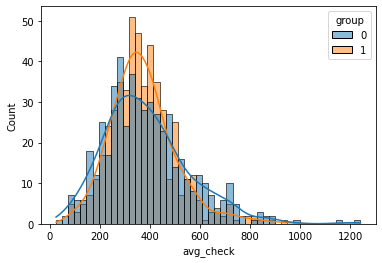

In [41]:
sns.histplot(data = avg_checks, x ="avg_check", hue = 'group', bins = 50, kde=True)

In [42]:
#The distribution is different from normal in both groups. There are outliers
#Let's look at the descriptives
avg_checks.groupby('group', as_index = False).avg_check.describe()

group  0       0.000000
       1       1.000000
count  0     512.000000
       1     501.000000
mean   0     386.039053
       1     371.203622
std    0     172.036518
       1     131.242699
min    0      25.000000
       1      83.500000
25%    0     268.881818
       1     286.066667
50%    0     362.666667
       1     355.925000
75%    0     475.883333
       1     434.437500
max    0    1240.800000
       1     937.400000
dtype: float64

In [43]:
stats.kurtosis(avg_checks.query("group == 0").avg_check, bias=False)

1.8231805471126101

In [44]:
stats.skew(avg_checks.query("group == 0").avg_check, bias=False)

0.9554594363951633

In [45]:
stats.kurtosis(avg_checks.query("group == 1").avg_check, bias=False)

1.7418948435355182

In [46]:
stats.skew(avg_checks.query("group == 1").avg_check, bias=False)

0.8678148692330684

Skewness and kurtosis are within the acceptable range of -2 to 2 ((George & Mallery, 2010), https://imaging.mrc-cbu.cam.ac.uk/statswiki/FAQ/Simon ). In addition, SD is less than half the mean in both groups (Mishra et al., 2019). Given that each group has more than 500 users, we can use the t-test

In [47]:
control = avg_checks.query("group == 0").avg_check
test = avg_checks.query("group == 1").avg_check
stats.ttest_ind(control, test)

Ttest_indResult(statistic=1.5407052777251002, pvalue=0.12370144988523067)

The differences are not significant. The change in the recommendation system did not affect the average check

Let's look at the total check

In [48]:
total_checks = finished_checks.groupby(['user_id','group'], as_index = False).agg(total_check=('check', 'sum'))

In [49]:
total_checks

,user_id,group,total_check
0,964,0,718.9
1,965,1,4155.5
2,967,1,1137.4
3,968,0,1590.7
4,969,0,681.9
...,...,...,...
1008,1976,1,2001.9
1009,1977,1,781.2
1010,1978,1,2276.3
1011,1979,1,1907.1


In [50]:
#Let's look at the distribution
pg.normality(data=total_checks, dv="total_check", group="group", method="normaltest")

,W,pval,normal
0,165.141459,1.380345e-36,False
1,21.243034,2.438562e-05,False


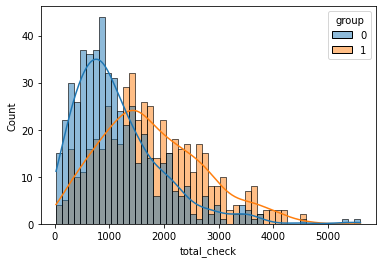

In [51]:
sns.histplot(data = total_checks, x ="total_check", hue = 'group', bins = 50, kde=True)

The data are skewed to the left. Let's look at the discriptives

In [46]:
total_checks.groupby('group', as_index = False).total_check.describe()

group  0       0.000000
       1       1.000000
count  0     512.000000
       1     501.000000
mean   0    1139.562305
       1    1753.749301
std    0     809.808924
       1     928.760937
min    0      25.000000
       1      83.500000
25%    0     571.700000
       1    1065.800000
50%    0     955.700000
       1    1630.100000
75%    0    1498.600000
       1    2376.000000
max    0    5589.800000
       1    4576.200000
dtype: float64

The SD is higher than half the mean, and together with the graphs we decide not to use t-test on raw data. Let's log-transform the data

In [52]:
#Minimum is greater than 0, so we can use the original data
total_checks['log_check']= np.log(total_checks.total_check)

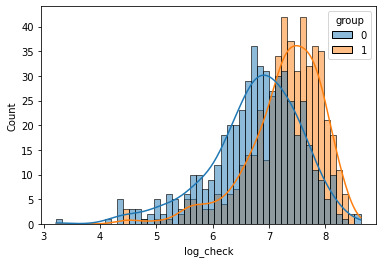

In [53]:
sns.histplot(data = total_checks, x ="log_check", hue = 'group', bins = 50, kde=True)

In [54]:
#The data are skewed to the right
pg.normality(data=total_checks, dv="log_check", group="group", method="normaltest")

,W,pval,normal
0,58.302072,2.187086e-13,False
1,109.161585,1.976347e-24,False


In [55]:
total_checks.groupby('group', as_index = False).log_check.describe()

group  0      0.000000
       1      1.000000
count  0    512.000000
       1    501.000000
mean   0      6.768319
       1      7.287983
std    0      0.806722
       1      0.678502
min    0      3.218876
       1      4.424847
25%    0      6.348614
       1      6.971481
50%    0      6.862443
       1      7.396397
75%    0      7.312277
       1      7.773174
max    0      8.628699
       1      8.428624
dtype: float64

After the transformation, the descriptives became better, the median is almost equal to the mean. Let's try to conduct a t-test, given the large sample size

In [56]:
control2 = total_checks.query("group == 0").log_check
test2 = total_checks.query("group == 1").log_check
stats.ttest_ind(control2, test2)

Ttest_indResult(statistic=-11.083914022889402, pvalue=5.032969014294083e-27)

The differences are significant. Let's look at the graph.

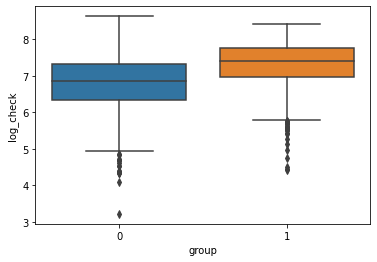

In [53]:
sns.boxplot(x='group', y='log_check', data=total_checks)

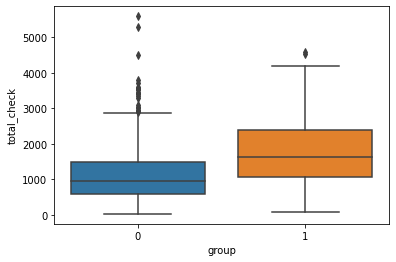

In [54]:
sns.boxplot(x='group', y='total_check', data=total_checks)

In [69]:
#Interpretation of the log-transformed data is complicated, because we got differences in logarithmic (not raw) values
#To understand what to do with the interpretation, let's conduct a t-test on the original data, as we have pretty large groups
control3 = total_checks.query("group == 0").total_check
test3 = total_checks.query("group == 1").total_check
stats.ttest_ind(control3, test3)
#The differences are significant

Ttest_indResult(statistic=-11.225235903309473, pvalue=1.2229806926590577e-27)

The implementation of the new system contributed to an average increase in revenue of 54%

Let's check the number of completed orders

In [57]:
finished_orders_count = finished_orders.groupby(['user_id','group'], as_index = False).agg(orders_number=('order_id','nunique'))

In [58]:
finished_orders_count.groupby('group', as_index = False).orders_number.describe()

group  0      0.000000
       1      1.000000
count  0    512.000000
       1    501.000000
mean   0      2.982422
       1      4.754491
std    0      1.886631
       1      2.138599
min    0      1.000000
       1      1.000000
25%    0      2.000000
       1      3.000000
50%    0      3.000000
       1      5.000000
75%    0      4.000000
       1      6.000000
max    0     13.000000
       1     12.000000
dtype: float64

In [59]:
finished_orders_count

,user_id,group,orders_number
0,964,0,2
1,965,1,9
2,967,1,5
3,968,0,3
4,969,0,2
...,...,...,...
1008,1976,1,5
1009,1977,1,4
1010,1978,1,6
1011,1979,1,5


In [60]:
#Let's look at the distribution
pg.normality(data=finished_orders_count, dv="orders_number", group="group", method="normaltest")

,W,pval,normal
0,178.266627,1.949368e-39,False
1,17.210719,1.831217e-04,False


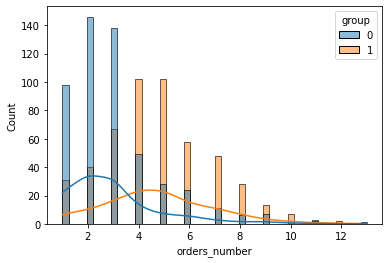

In [61]:
sns.histplot(data = finished_orders_count, x ="orders_number", hue = 'group', bins = 50, kde=True)

In [62]:
#The distribution is definitely different from normal.
finished_orders_count['log_number']= np.log(finished_orders_count.orders_number)

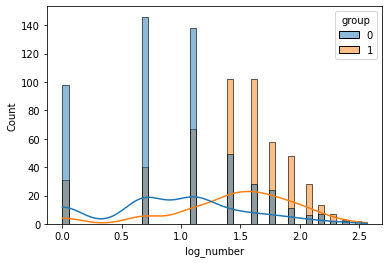

In [63]:
sns.histplot(data = finished_orders_count, x ="log_number", hue = 'group', bins = 50, kde=True)

In [63]:
finished_orders_count.groupby('group', as_index = False).log_number.describe()

group  0      0.000000
       1      1.000000
count  0    512.000000
       1    501.000000
mean   0      0.918029
       1      1.435715
std    0      0.591894
       1      0.540601
min    0      0.000000
       1      0.000000
25%    0      0.693147
       1      1.098612
50%    0      1.098612
       1      1.609438
75%    0      1.386294
       1      1.791759
max    0      2.564949
       1      2.484907
dtype: float64

In [77]:
#The situation has not improved, let's perform bootstrapping and compare the medians
pg.compute_bootci(finished_orders_count.query("group == 0").orders_number,
                  finished_orders_count.query("group == 1").orders_number,
                  func=lambda x, y: np.median(x) - np.median(y),
                 confidence = 0.9875) 

#adjusting the confidence interval to a p-value = 1-0.0125 = 0.9875

array([-3., -1.])

A statistically significant effect was found, as the confidence interval doesn't include 0. Let's look at the graph

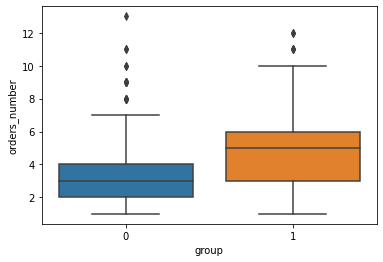

In [67]:
sns.boxplot(x='group', y='orders_number', data=finished_orders_count)

The implementation of the new recommendation system contributed to a significant increase in the number of completed orders per user (67%)

Let's check the number of cancelled orders

In [68]:
canceled_orders_count = orders_users.query('action == "cancel_order"').groupby(['user_id','group'], as_index = False).agg(orders_number=('order_id','nunique'))

In [69]:
canceled_orders_count.groupby('group', as_index = False).orders_number.describe()

group  0      0.000000
       1      1.000000
count  0     76.000000
       1    113.000000
mean   0      1.078947
       1      1.168142
std    0      0.271448
       1      0.398718
min    0      1.000000
       1      1.000000
25%    0      1.000000
       1      1.000000
50%    0      1.000000
       1      1.000000
75%    0      1.000000
       1      1.000000
max    0      2.000000
       1      3.000000
dtype: float64

In [70]:
#Checking the distribution
pg.normality(data=canceled_orders_count, dv="orders_number", group="group", method="normaltest")

,W,pval,normal
0,69.857481,6.770813e-16,False
1,61.435658,4.564744e-14,False


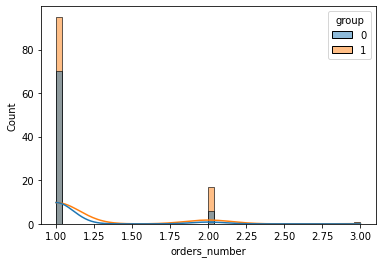

In [71]:
sns.histplot(data = canceled_orders_count, x ="orders_number", hue = 'group', bins = 50, kde=True)

In [72]:
#Here it is better to use a chi-square
stat, p, dof, expected = chi2_contingency(pd.crosstab(canceled_orders_count.group, canceled_orders_count.orders_number))

In [73]:
stat, p

(2.9171617350066534, 0.23256608273941526)

The introduction of the new recommendation system did not have a significant impact on the number of cancelled orders

**Conclusion** Thus, the implementation of the new recommendation system did not significantly affect the average user check, but contributed to a significant increase in total revenue (54%) and the number of uncancelled orders (67%), not affecting the number of canceled orders. Therefore, its implementation is advisable.